<a href="https://colab.research.google.com/github/sathishkumar118/Introduction_to_GAN/blob/main/GANs_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings(action="default")

In [2]:
# imports
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras

import numpy as np
import matplotlib.pyplot as plt


/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
x_train = (x_train - 127.5)/127.5

print(x_train.min())
print(x_train.max())

-1.0
1.0


In [5]:
TOTAL_EPOCHS = 50
BATCH_SIZE = 256
HALF_BATCH = int(BATCH_SIZE/2)

NO_OF_BATCHES = int(x_train.shape[0]/BATCH_SIZE)

NOISE_DIM = 100
adam = Adam(learning_rate = 2e-4, beta_1=0.5)

# Generator Model

In [6]:
generator = Sequential()
generator.add(Dense(units= 7*7*128, input_shape = (NOISE_DIM,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(64, (3,3), strides = (2,2), padding = 'same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(1, (3,3), strides=(2,2), padding='same', activation='tanh'))
generator.compile(loss = keras.losses.binary_crossentropy, optimizer = adam)

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        73792     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        2

# Descriminator Model

In [7]:
descriminator = Sequential()
descriminator.add(Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', input_shape = (28,28,1)))
descriminator.add(LeakyReLU(0.2))

descriminator.add(Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same'))
descriminator.add(LeakyReLU(0.2))

descriminator.add(Flatten())
descriminator.add(Dense(100))
descriminator.add(LeakyReLU(0.2))

descriminator.add(Dense(1, activation='sigmoid'))
descriminator.compile(loss = keras.losses.binary_crossentropy, optimizer = adam)

descriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               627300    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 100)              

# Combined Model

In [8]:
descriminator.trainable = False

gan_input = Input(shape = (NOISE_DIM))

generated_img = generator(gan_input)

gan_output = descriminator(generated_img)

model = Model(gan_input, gan_output)
model.compile(loss = keras.losses.binary_crossentropy, optimizer = adam)

In [9]:
x_train = x_train.reshape(-1,28,28,1)

In [10]:
x_train.shape

(60000, 28, 28, 1)

In [13]:
def display_images(samples = 25):
  noise = np.random.normal(0,1,size = (samples, NOISE_DIM))

  generated_img = generator.predict(noise)

  plt.figure(figsize = (10,10))
  for i in range(samples):
    plt.subplot(5,5,i+1)
    plt.imshow(generated_img[i].reshape(28,28), cmap = "binary")
    plt.axis('off')
  plt.show()

Epoch 1, Disc loss 0.6371858089398115, Generaotor loss 1.142069729984316
Epoch 2, Disc loss 0.634886771440506, Generaotor loss 1.147815812856723
Epoch 3, Disc loss 0.6318056272645282, Generaotor loss 1.1546099914444818
Epoch 4, Disc loss 0.6292393506210074, Generaotor loss 1.165387563725822
Epoch 5, Disc loss 0.6262593618952311, Generaotor loss 1.1752531518284073
Epoch 6, Disc loss 0.6226299866779238, Generaotor loss 1.1944863052449675
Epoch 7, Disc loss 0.619685756536121, Generaotor loss 1.2038305478218274
Epoch 8, Disc loss 0.6198191111668562, Generaotor loss 1.2167727142317681
Epoch 9, Disc loss 0.6152576782509812, Generaotor loss 1.2284696423090422
Epoch 10, Disc loss 0.613631496954168, Generaotor loss 1.2473427770484207


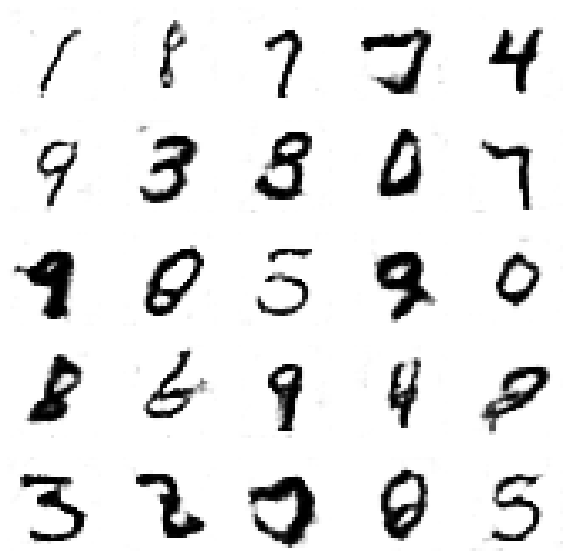

Epoch 11, Disc loss 0.6087950185323373, Generaotor loss 1.2610207113445315
Epoch 12, Disc loss 0.6051998356850739, Generaotor loss 1.2824297888666136
Epoch 13, Disc loss 0.6016531482211545, Generaotor loss 1.2957147161165874
Epoch 14, Disc loss 0.5984103632533652, Generaotor loss 1.322483763226077
Epoch 15, Disc loss 0.5942923104406422, Generaotor loss 1.3318369582168057
Epoch 16, Disc loss 0.5894636426471237, Generaotor loss 1.3591415607012236
Epoch 17, Disc loss 0.5854878821052037, Generaotor loss 1.3874880167154164
Epoch 18, Disc loss 0.5828462930189239, Generaotor loss 1.4035005039638944
Epoch 19, Disc loss 0.5785230797452804, Generaotor loss 1.4247535543564038
Epoch 20, Disc loss 0.5752613273186561, Generaotor loss 1.4442617618120634


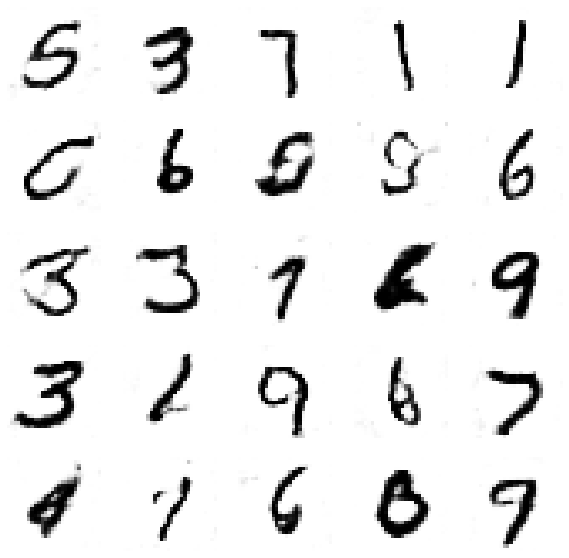

Epoch 21, Disc loss 0.5725451343589358, Generaotor loss 1.4703177442917457
Epoch 22, Disc loss 0.5673040997268807, Generaotor loss 1.4887546255038335
Epoch 23, Disc loss 0.5671495385149605, Generaotor loss 1.5077159919290462
Epoch 24, Disc loss 0.5604112492794664, Generaotor loss 1.5301148152758932
Epoch 25, Disc loss 0.5586840607162215, Generaotor loss 1.550447380440867
Epoch 26, Disc loss 0.5548340420947115, Generaotor loss 1.5708321450103042
Epoch 27, Disc loss 0.5516558735925927, Generaotor loss 1.5891848761811216
Epoch 28, Disc loss 0.5472809047653124, Generaotor loss 1.613529459024087
Epoch 29, Disc loss 0.5461959163857322, Generaotor loss 1.6359362872237833
Epoch 30, Disc loss 0.5438058962806677, Generaotor loss 1.6490362862236478


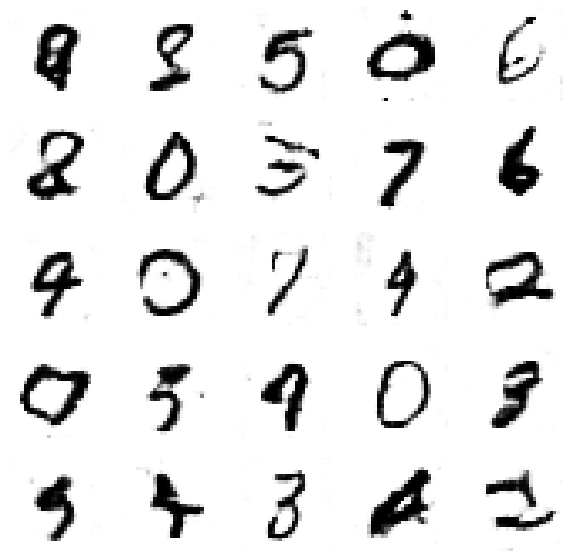

Epoch 31, Disc loss 0.541996602446605, Generaotor loss 1.6736630415305114
Epoch 32, Disc loss 0.5397346147742027, Generaotor loss 1.6779362060065963
Epoch 33, Disc loss 0.5346317223121977, Generaotor loss 1.699000375902551
Epoch 34, Disc loss 0.5349979862316042, Generaotor loss 1.7244528262024252
Epoch 35, Disc loss 0.5296488888243325, Generaotor loss 1.7408373218316298
Epoch 36, Disc loss 0.5264019161208063, Generaotor loss 1.75917358072395
Epoch 37, Disc loss 0.5245385908672953, Generaotor loss 1.7833036357520993
Epoch 38, Disc loss 0.523447399529127, Generaotor loss 1.7981340691574619
Epoch 39, Disc loss 0.5230416709668616, Generaotor loss 1.809731578725016
Epoch 40, Disc loss 0.5173281492331089, Generaotor loss 1.831144934026604


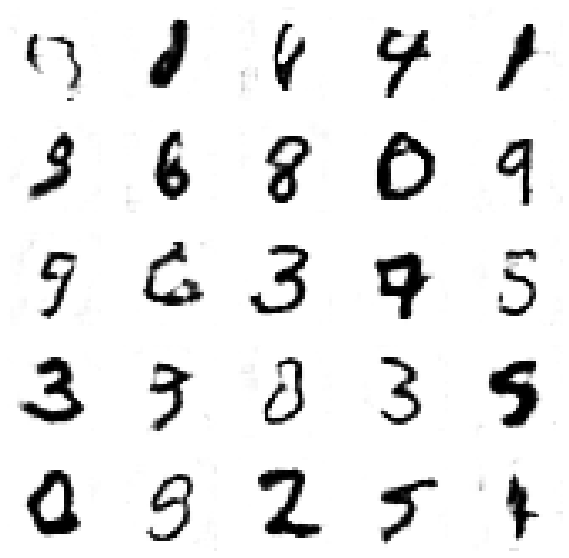

Epoch 41, Disc loss 0.5160846510886127, Generaotor loss 1.849165858875992
Epoch 42, Disc loss 0.5147443225241115, Generaotor loss 1.856607637853704
Epoch 43, Disc loss 0.5121514607443769, Generaotor loss 1.8690733242238688
Epoch 44, Disc loss 0.5112843431978145, Generaotor loss 1.8885630506735582
Epoch 45, Disc loss 0.507178900588272, Generaotor loss 1.9102338338509584
Epoch 46, Disc loss 0.5055505799559447, Generaotor loss 1.9206562383562071
Epoch 47, Disc loss 0.5068445715766686, Generaotor loss 1.9178079657065563
Epoch 48, Disc loss 0.5031327111726134, Generaotor loss 1.9413155587310464
Epoch 49, Disc loss 0.5007800494885852, Generaotor loss 1.954826859327463
Epoch 50, Disc loss 0.4992262826133997, Generaotor loss 1.9559825516154623


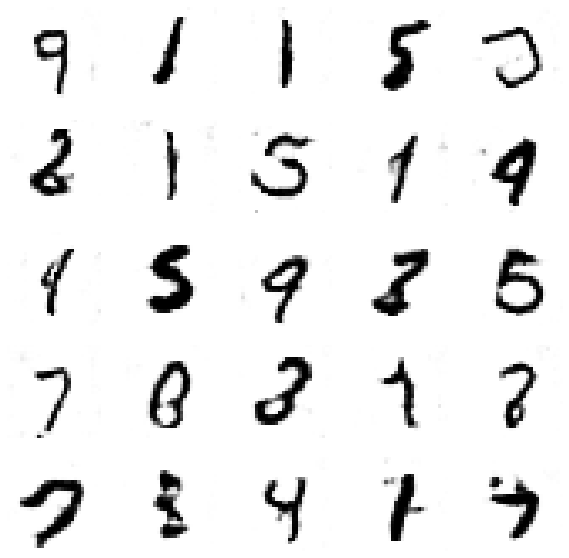

In [14]:
d_losses = []
g_losses = []

for epoch in range(TOTAL_EPOCHS):
  epoch_d_loss = 0.0
  epoch_g_loss = 0.0

  for step in range(NO_OF_BATCHES):
    # Train Descriminator
    descriminator.trainable = True

    idx = np.random.randint(0, 60000, HALF_BATCH)
    real_imgs = x_train[idx]

    noise = np.random.normal(0,1, size = (HALF_BATCH, NOISE_DIM))
    fake_imgs = generator.predict(noise)

    real_y = np.ones((HALF_BATCH, 1))*0.9
    fake_y = np.zeros((HALF_BATCH, 1))

    d_loss_real = descriminator.train_on_batch(real_imgs, real_y)
    d_loss_fake = descriminator.train_on_batch(fake_imgs, fake_y)

    d_loss = 0.5*d_loss_real + 0.5*d_loss_fake

    epoch_d_loss += d_loss

    # Train Generator
    descriminator.trainable = False
    noise = np.random.normal(0,1,size = (BATCH_SIZE, NOISE_DIM))
    ground_truth_y = np.ones((BATCH_SIZE, 1))
    
    g_loss = model.train_on_batch(noise, ground_truth_y)
    epoch_g_loss += g_loss

  print(f"Epoch {epoch+1}, Disc loss {epoch_d_loss/NO_OF_BATCHES}, Generator loss {epoch_g_loss/NO_OF_BATCHES}")

  d_losses.append(epoch_d_loss/NO_OF_BATCHES)
  g_losses.append(epoch_g_loss/NO_OF_BATCHES)

  if(epoch+1)%10 == 0:
    generator.save("generator.h5")
    display_images()